# Analisis Sentimen Komentar YouTube

Notebook ini berisi analisis sentimen terhadap komentar YouTube menggunakan machine learning. Proses meliputi eksplorasi data, penanganan imbalance, pemodelan, dan analisis fitur.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Load Data dan Eksplorasi Awal

Memuat dataset yang sudah dipreprocessing dan memeriksa distribusi kelas sentimen.

In [58]:
df_full = pd.read_csv('data_preprocessed.csv')
df_full = df_full.dropna(subset=['teks_final', 'sentiment'])

print(f"Total Data Awal: {len(df_full)}")
print("Distribusi Kelas Awal:")
print(df_full['sentiment'].value_counts())

Total Data Awal: 1072
Distribusi Kelas Awal:
sentiment
Positif    691
Netral     202
Negatif    179
Name: count, dtype: int64


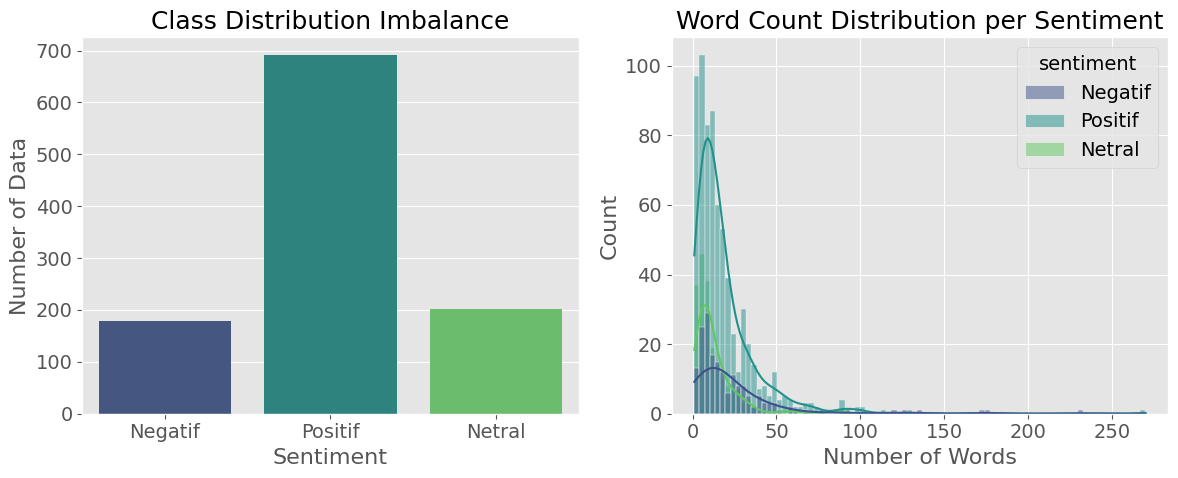

In [76]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='sentiment', data=df_full, palette='viridis')
plt.title('Class Distribution Imbalance')
plt.xlabel('Sentiment')
plt.ylabel('Number of Data')

plt.subplot(1, 2, 2)
df_full['panjang_kata'] = df_full['teks_final'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df_full, x='panjang_kata', hue='sentiment', kde=True, palette='viridis')
plt.title('Word Count Distribution per Sentiment')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

### Word Cloud Topik Diskusi

Visualisasi kata-kata yang paling sering muncul dalam komentar secara keseluruhan.

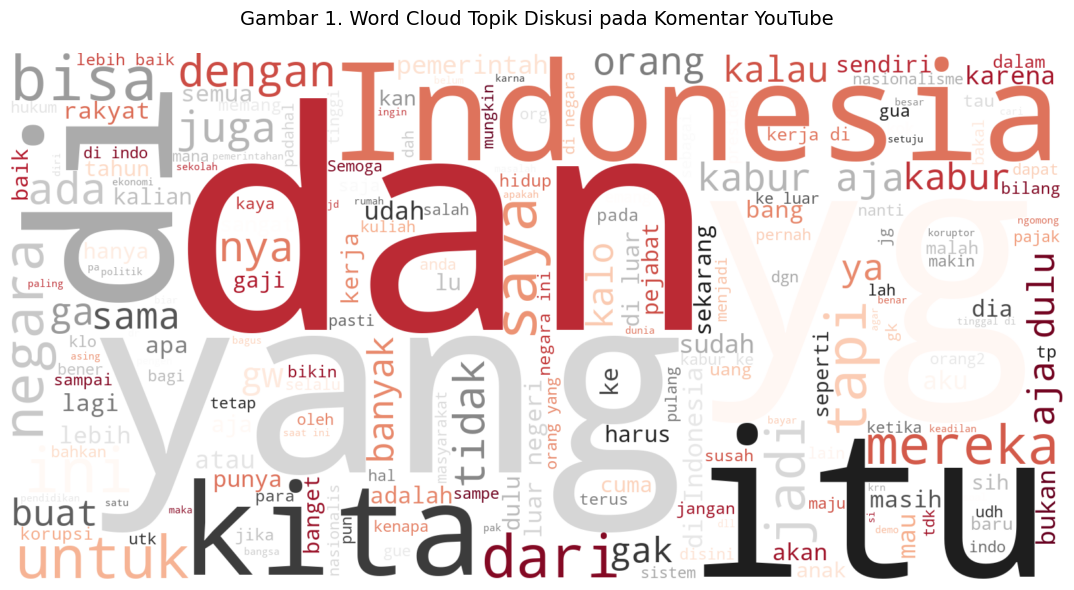

✅ Gambar 1 berhasil disimpan dengan data asli!


In [60]:
df = pd.read_csv('dataset_labeled.csv')

text_corpus = " ".join(comment for comment in df['Teks_Komentar'].astype(str))

wordcloud = WordCloud(width=1600, height=800,
                      background_color='white',
                      colormap='RdGy', # Merah-Abu (Nuansa serius/kritik)
                      min_font_size=10).generate(text_corpus)

# 4. Tampilkan & Simpan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Gambar 1. Word Cloud Topik Diskusi pada Komentar YouTube", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('Gambar1_WordCloud_Asli.png', dpi=300)
plt.show()

### Eksperimen: Pengaruh Kelas Netral

Membandingkan performa model dengan 3 kelas (Positif, Netral, Negatif) vs 2 kelas (Positif, Negatif) untuk menentukan strategi pemodelan yang optimal.

                      Scenario  Accuracy  F1-Score
0     3 Classes (With Neutral)  0.572093  0.569509
1  2 Classes (Without Neutral)  0.718391  0.713783


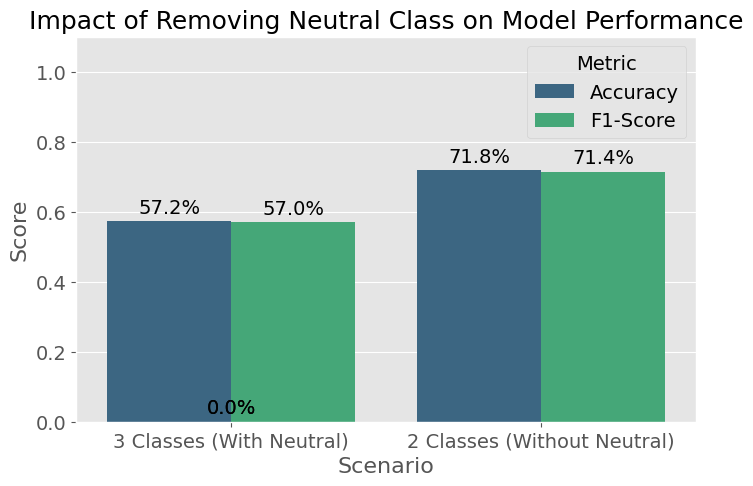

In [79]:
def run_experiment_scenario(df_input, scenario_name):
    X = df_input['teks_final']
    y = df_input['sentiment']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    model = SVC(kernel='linear', class_weight='balanced')
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

acc_3, f1_3 = run_experiment_scenario(df_full, "3 Classes (Pos, Neu, Neg)")

df_2class = df_full[df_full['sentiment'] != 'Netral'].copy()
acc_2, f1_2 = run_experiment_scenario(df_2class, "2 Classes (Pos, Neg)")

results = pd.DataFrame({
    'Scenario': ['3 Classes (With Neutral)', '2 Classes (Without Neutral)'],
    'Accuracy': [acc_3, acc_2],
    'F1-Score': [f1_3, f1_2]
})

print(results)

plt.figure(figsize=(8, 5))
df_melted = results.melt(id_vars='Scenario', var_name='Metric', value_name='Score')
ax = sns.barplot(x='Scenario', y='Score', hue='Metric', data=df_melted, palette='viridis')
plt.title('Impact of Removing Neutral Class on Model Performance')
plt.ylim(0, 1.1)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

### Persiapan Data untuk Modeling

Split data train-test dan vektorisasi menggunakan TF-IDF.

## Modelling

In [62]:
df = df_full[df_full['sentiment'] != 'Netral'].copy()
print(f"Menggunakan {len(df)} data (Hanya Positif & Negatif) untuk analisis utama.")

X = df['teks_final']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

print(f"Vocabulary Size: {len(vectorizer.vocabulary_)}")

Menggunakan 870 data (Hanya Positif & Negatif) untuk analisis utama.
Vocabulary Size: 5000


### Eksperimen: Undersampling

Menguji pendekatan undersampling untuk menangani ketidakseimbangan kelas. Metode ini mengurangi kelas mayoritas agar seimbang dengan kelas minoritas.

==================== EKSPERIMEN UNDERSAMPLING ====================
Data FULL (3 Kelas):
  Train: {'Positif': 552, 'Netral': 162, 'Negatif': 143}
  Test : {'Positif': 139, 'Netral': 40, 'Negatif': 36}

Data Train Asli   : (857, 5000)
Data Train Potong : (429, 5000) (Info hilang banyak!)
Distribusi Setelah Undersampling: {'Negatif': 143, 'Netral': 143, 'Positif': 143}

--- Hasil Model Undersampling (3 Kelas: Pos, Net, Neg) ---
              precision    recall  f1-score   support

     Negatif       0.33      0.61      0.43        36
      Netral       0.27      0.40      0.32        40
     Positif       0.76      0.49      0.60       139

    accuracy                           0.49       215
   macro avg       0.45      0.50      0.45       215
weighted avg       0.60      0.49      0.52       215



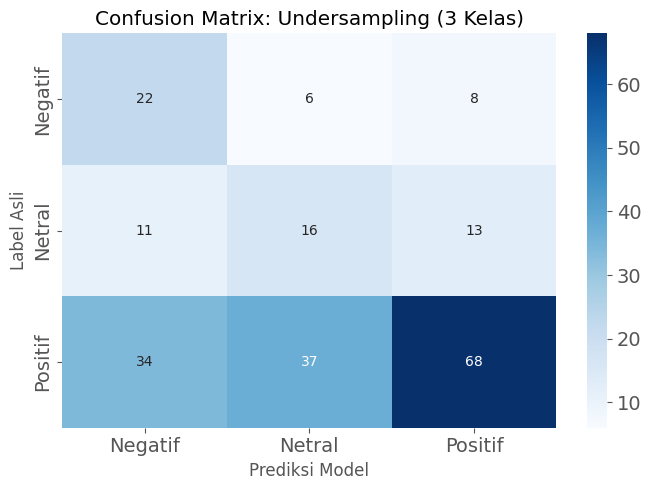

In [63]:
from imblearn.under_sampling import RandomUnderSampler

print(f"{'='*20} EKSPERIMEN UNDERSAMPLING {'='*20}")

X_full = df_full['teks_final']
y_full = df_full['sentiment']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

vectorizer_full = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_full_vect = vectorizer_full.fit_transform(X_train_full)
X_test_full_vect = vectorizer_full.transform(X_test_full)

print(f"Data FULL (3 Kelas):")
print(f"  Train: {y_train_full.value_counts().to_dict()}")
print(f"  Test : {y_test_full.value_counts().to_dict()}")

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_full_vect, y_train_full)

print(f"\nData Train Asli   : {X_train_full_vect.shape}") 
print(f"Data Train Potong : {X_train_rus.shape} (Info hilang banyak!)")
print(f"Distribusi Setelah Undersampling: {pd.Series(y_train_rus).value_counts().to_dict()}")

model_rus = SVC(kernel='linear')
model_rus.fit(X_train_rus, y_train_rus)

y_pred_rus = model_rus.predict(X_test_full_vect)
print("\n--- Hasil Model Undersampling (3 Kelas: Pos, Net, Neg) ---")
print(classification_report(y_test_full, y_pred_rus))

cm_rus = confusion_matrix(y_test_full, y_pred_rus)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_rus, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negatif', 'Netral', 'Positif'], 
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title('Confusion Matrix: Undersampling (3 Kelas)')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi Model')
plt.tight_layout()
plt.show()

### Perbandingan Model: Naive Bayes vs SVM

Membandingkan performa dua algoritma klasifikasi untuk analisis sentimen.


==================== Naive Bayes ====================
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        36
     Positif       0.79      1.00      0.88       138

    accuracy                           0.79       174
   macro avg       0.40      0.50      0.44       174
weighted avg       0.63      0.79      0.70       174


==================== SVM (Balanced) ====================
              precision    recall  f1-score   support

     Negatif       0.34      0.33      0.34        36
     Positif       0.83      0.83      0.83       138

    accuracy                           0.73       174
   macro avg       0.59      0.58      0.58       174
weighted avg       0.73      0.73      0.73       174



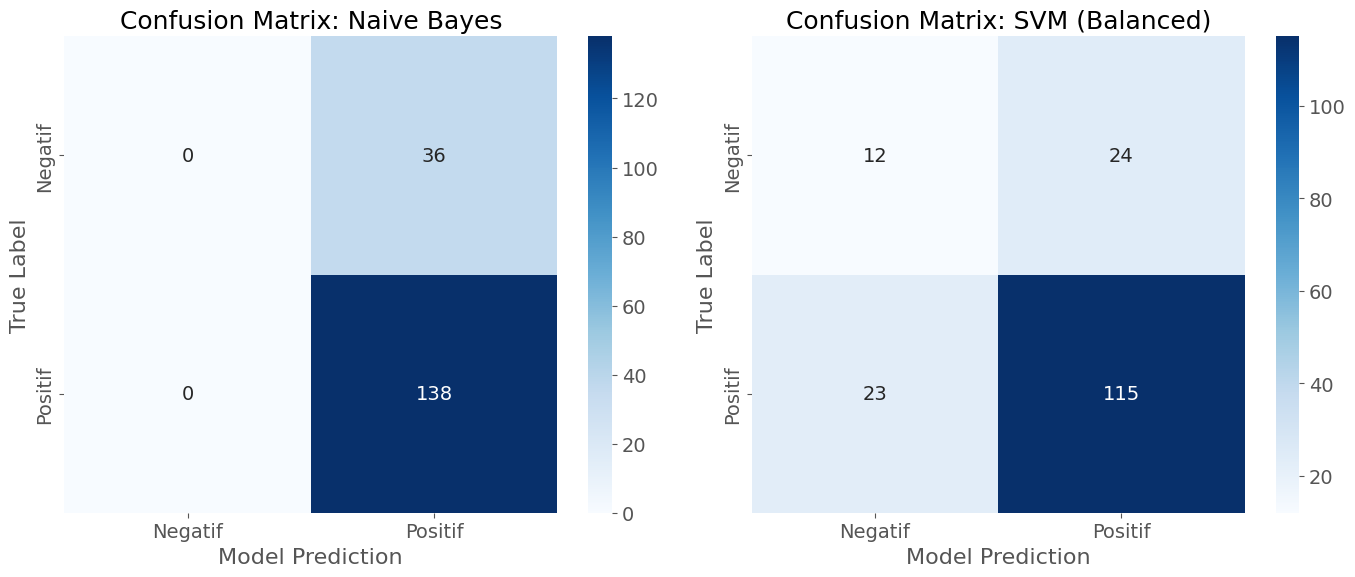

In [77]:
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (Balanced)": SVC(kernel='linear', class_weight='balanced')
}

plt.figure(figsize=(14, 6))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    
    print(f"\n{'='*20} {name} {'='*20}")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Model Prediction')

plt.tight_layout()
plt.show()

### Eksperimen: SMOTE vs Class Weighting

Membandingkan dua pendekatan untuk menangani imbalance:
- Class Weighting: Menyesuaikan bobot kelas di level algoritma
- SMOTE: Menambah data sintetis untuk kelas minoritas

In [65]:
from imblearn.over_sampling import SMOTE

print(f"{'='*20} EKSPERIMEN HANDLING IMBALANCE {'='*20}")

# 1. Baseline: SVM dengan Class Weight (Cara kamu sekarang)
print("\n--- Model A: SVM dengan Class Weight (Algorithmic Level) ---")
model_a = SVC(kernel='linear', class_weight='balanced')
model_a.fit(X_train_vect, y_train)
y_pred_a = model_a.predict(X_test_vect)
print(classification_report(y_test, y_pred_a))

# 2. Challenger: SVM dengan SMOTE (Data Level)
print("\n--- Model B: SVM dengan SMOTE (Data Level) ---")
# SMOTE hanya diterapkan di data TRAIN, jangan di data TEST!
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vect, y_train)

print(f"Data Train Asli: {X_train_vect.shape}")
print(f"Data Train SMOTE: {X_train_smote.shape} (Sudah seimbang)")

model_b = SVC(kernel='linear') # Tanpa class weight karena data sudah seimbang
model_b.fit(X_train_smote, y_train_smote)
y_pred_b = model_b.predict(X_test_vect)
print(classification_report(y_test, y_pred_b))

==================== EKSPERIMEN HANDLING IMBALANCE ====================

--- Model A: SVM dengan Class Weight (Algorithmic Level) ---
              precision    recall  f1-score   support

     Negatif       0.34      0.33      0.34        36
     Positif       0.83      0.83      0.83       138

    accuracy                           0.73       174
   macro avg       0.59      0.58      0.58       174
weighted avg       0.73      0.73      0.73       174


--- Model B: SVM dengan SMOTE (Data Level) ---
Data Train Asli: (696, 5000)
Data Train SMOTE: (1106, 5000) (Sudah seimbang)
              precision    recall  f1-score   support

     Negatif       0.42      0.28      0.33        36
     Positif       0.83      0.90      0.86       138

    accuracy                           0.77       174
   macro avg       0.62      0.59      0.60       174
weighted avg       0.74      0.77      0.75       174



## Analisis Feature Importance

Mengidentifikasi kata-kata kunci yang paling berpengaruh dalam menentukan sentimen positif dan negatif berdasarkan bobot SVM.

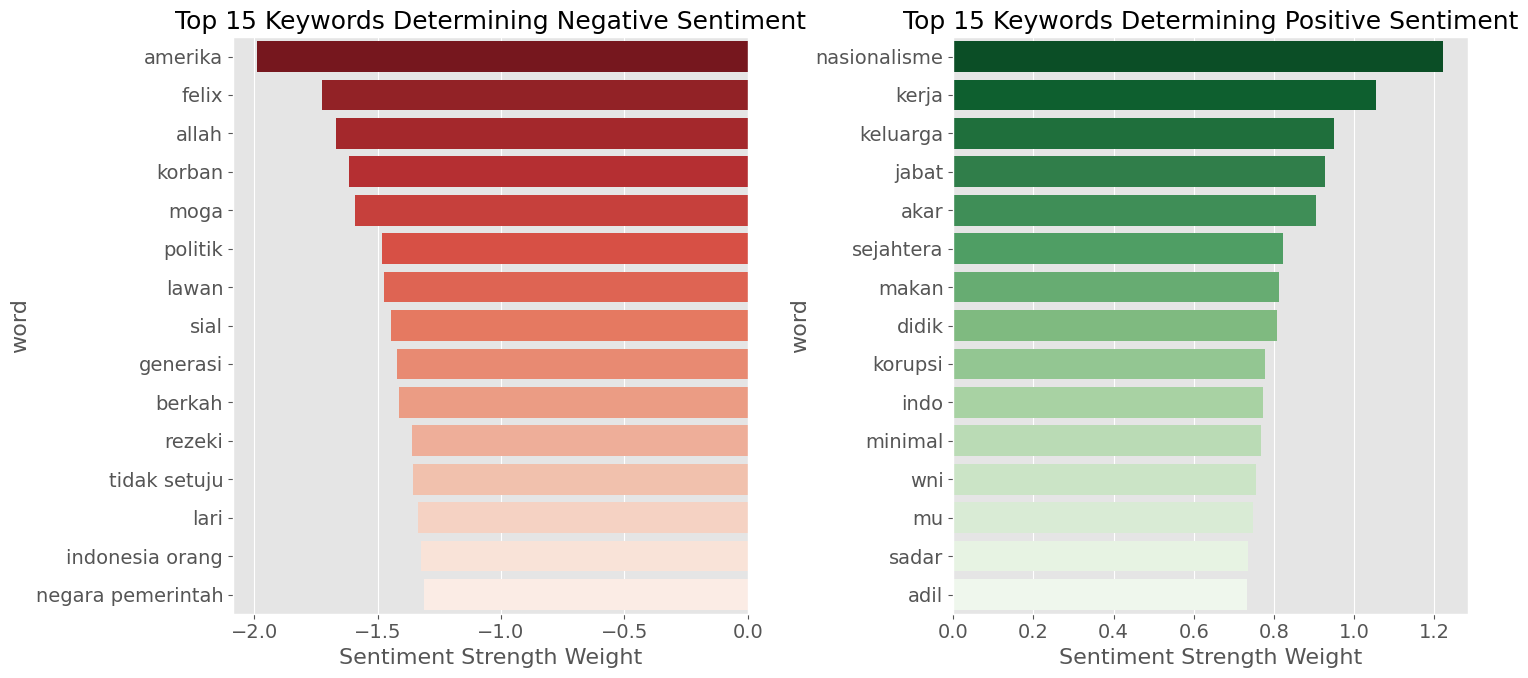

Top Negative Words: ['amerika', 'felix', 'allah', 'korban', 'moga', 'politik', 'lawan', 'sial', 'generasi', 'berkah', 'rezeki', 'tidak setuju', 'lari', 'indonesia orang', 'negara pemerintah']
Top Positive Words: ['nasionalisme', 'kerja', 'keluarga', 'jabat', 'akar', 'sejahtera', 'makan', 'didik', 'korupsi', 'indo', 'minimal', 'wni', 'mu', 'sadar', 'adil']


In [78]:
model_svm = models["SVM (Balanced)"]
feature_names = vectorizer.get_feature_names_out()
coefs = model_svm.coef_.toarray()[0]

df_features = pd.DataFrame({'word': feature_names, 'weight': coefs})

top_neg = df_features.sort_values(by='weight', ascending=True).head(15)
top_pos = df_features.sort_values(by='weight', ascending=False).head(15)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.barplot(data=top_neg, x='weight', y='word', palette='Reds_r')
plt.title('Top 15 Keywords Determining Negative Sentiment')
plt.xlabel('Sentiment Strength Weight')

plt.subplot(1, 2, 2)
sns.barplot(data=top_pos, x='weight', y='word', palette='Greens_r')
plt.title('Top 15 Keywords Determining Positive Sentiment')
plt.xlabel('Sentiment Strength Weight')

plt.tight_layout()
plt.show()

print("Top Negative Words:", top_neg['word'].tolist())
print("Top Positive Words:", top_pos['word'].tolist())

### Contoh Konteks Penggunaan Kata Kunci

Menampilkan contoh kalimat asli yang mengandung kata-kata kunci dari feature importance untuk memahami konteks penggunaannya.

In [67]:
def print_context_examples(df, feature_df, sentiment_target, n_keywords=5, n_examples=3):
    print(f"\n{'='*20} CONTOH KONTEKS: SENTIMEN {sentiment_target.upper()} {'='*20}")
    
    keywords = feature_df['kata'].head(n_keywords).tolist()
    
    for word in keywords:
        matches = df[
            (df['teks_final'].str.contains(word, na=False)) & 
            (df['sentiment'] == sentiment_target)
        ]
        
        print(f"\n[Fitur/Kata: '{word}'] (Ditemukan di {len(matches)} data)")
        
        if len(matches) > 0:
            samples = matches['Teks_Komentar'].sample(min(n_examples, len(matches)), random_state=42).tolist()
            for i, text in enumerate(samples):
                clean_text = text.replace('\n', ' ').strip()
                print(f"  {i+1}. \"{clean_text[:100]}...\"")
        else:
            print("  - Tidak ada contoh kalimat yang ditemukan.")

print_context_examples(df, top_neg, 'Negatif', n_keywords=5)
print_context_examples(df, top_pos, 'Positif', n_keywords=5)


==================== CONTOH KONTEKS: SENTIMEN NEGATIF ====================

[Fitur/Kata: 'amerika'] (Ditemukan di 7 data)
  1. "Kabur aja kalian semua dari pada bikin semak, lebih baik kalan kabur ke Amerika sono atau Eropa..."
  2. "GPP kabur aja dulu, asal di negara orang itu  lu kerja bener, dan kuat mental ketika disuru bayar TA..."
  3. "Kabur aja dulu itu hastag nya buzzer wkwkwkwk kabur aja dulu, lah lu enak punya akses, emang lu TKI...."

[Fitur/Kata: 'felix'] (Ditemukan di 15 data)
  1. "saya selalu bilang ke anak saya yg sekarang kelas 7smp kamu sekolah /kuliah /kerja di sini aja janga..."
  2. "Ko Raymond dan Ust Felix adalah 2 orang hebat di Indonesia diskusi tingkat dewa. Bismillah sukses un..."
  3. "Sistem tidak berjalan dengan baik ditambah oknum,  Tidak bisa ganti sistem,  Edukasi di ring luar da..."

[Fitur/Kata: 'allah'] (Ditemukan di 15 data)
  1. "Wahai para kompeni2😁.. dengerin nih dialog para kesatria sejati indonesia yg sesungguhnya!.  Ustadz ..."
  2. "Semoga 

### Word Cloud Berdasarkan Bobot SVM

Visualisasi kata-kata penting berdasarkan bobot feature yang dipelajari model SVM.

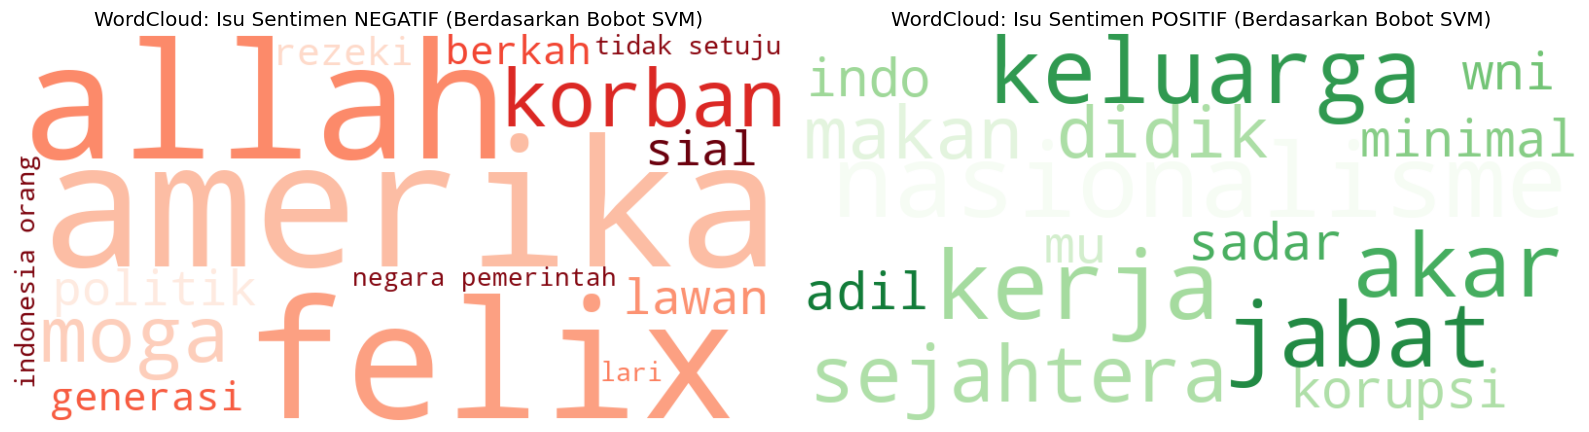

In [68]:
from wordcloud import WordCloud

data_pos = dict(zip(top_pos['kata'], top_pos['bobot']))
data_neg = dict(zip(top_neg['kata'], top_neg['bobot'].abs()))

wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens')
wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds')

wc_pos.generate_from_frequencies(data_pos)
wc_neg.generate_from_frequencies(data_neg)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('WordCloud: Isu Sentimen NEGATIF (Berdasarkan Bobot SVM)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title('WordCloud: Isu Sentimen POSITIF (Berdasarkan Bobot SVM)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Analisis Pola Linguistik

Menganalisis perbedaan karakteristik bahasa antara komentar positif dan negatif, termasuk panjang komentar dan kekayaan kosakata.

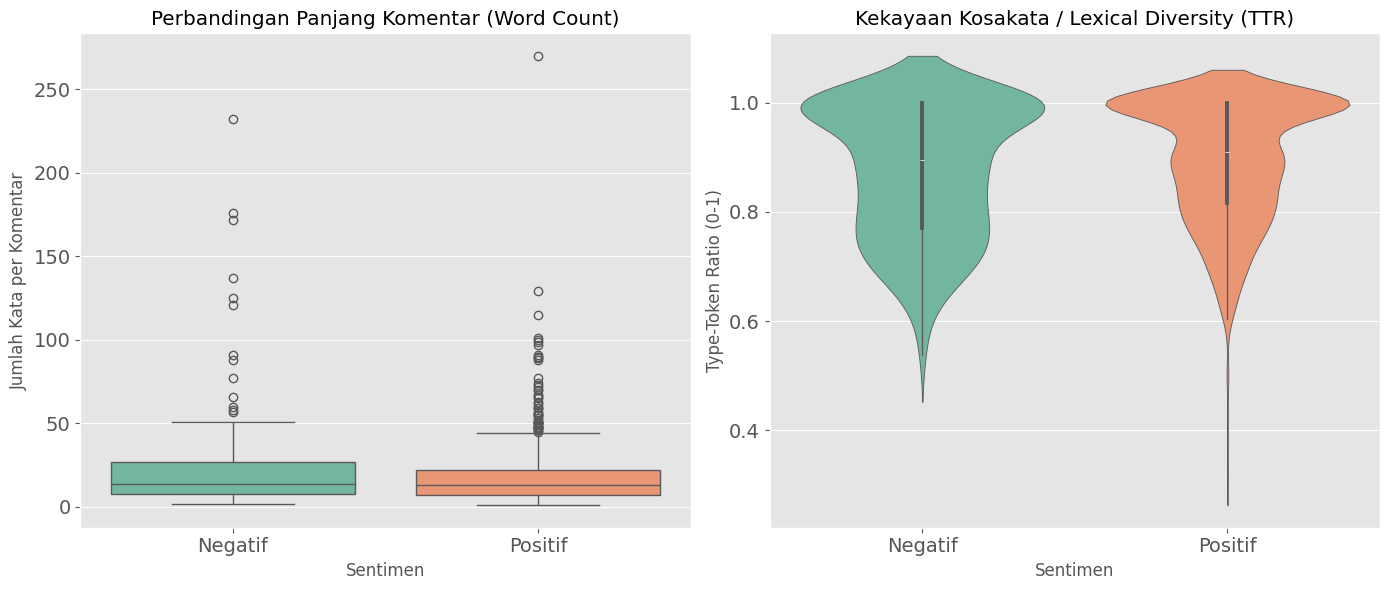

=== Statistik Komentar NEGATIF ===
       word_count      ttr
count     179.000  179.000
mean       24.073    0.874
std        30.890    0.121
min         2.000    0.538
25%         8.000    0.771
50%        14.000    0.895
75%        27.000    1.000
max       232.000    1.000

=== Statistik Komentar POSITIF ===
       word_count      ttr
count      691.00  691.000
mean        18.42    0.895
std         20.00    0.112
min          1.00    0.323
25%          7.00    0.817
50%         13.00    0.909
75%         22.00    1.000
max        270.00    1.000


In [69]:
# Pisahkan data berdasarkan sentimen
df_pos = df[df['sentiment'] == 'Positif'].copy()
df_neg = df[df['sentiment'] == 'Negatif'].copy()

# 1. Hitung Panjang Komentar (Jumlah Kata)
df_pos['word_count'] = df_pos['teks_final'].apply(lambda x: len(str(x).split()))
df_neg['word_count'] = df_neg['teks_final'].apply(lambda x: len(str(x).split()))

# 2. Hitung Lexical Richness (Rasio Kata Unik dibanding Total Kata)
# Semakin tinggi nilainya, semakin kaya/bervariasi bahasanya
def calculate_ttr(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

df_pos['ttr'] = df_pos['teks_final'].apply(calculate_ttr)
df_neg['ttr'] = df_neg['teks_final'].apply(calculate_ttr)

# --- Visualisasi Perbandingan ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribusi Panjang Kalimat
sns.boxplot(data=df, x='sentiment', y='panjang_kata', palette='Set2', ax=axes[0])
axes[0].set_title('Perbandingan Panjang Komentar (Word Count)')
axes[0].set_ylabel('Jumlah Kata per Komentar')
axes[0].set_xlabel('Sentimen')

# Plot 2: Distribusi Kekayaan Kosakata (TTR)
# Gabungkan data untuk plot TTR
df['ttr'] = df['teks_final'].apply(calculate_ttr)
sns.violinplot(data=df, x='sentiment', y='ttr', palette='Set2', ax=axes[1])
axes[1].set_title('Kekayaan Kosakata / Lexical Diversity (TTR)')
axes[1].set_ylabel('Type-Token Ratio (0-1)')
axes[1].set_xlabel('Sentimen')

plt.tight_layout()
plt.show()

# Print Statistik Deskriptif
print("=== Statistik Komentar NEGATIF ===")
print(df_neg[['word_count', 'ttr']].describe().round(3))
print("\n=== Statistik Komentar POSITIF ===")
print(df_pos[['word_count', 'ttr']].describe().round(3))

## Visualisasi Poster

### Setup Visualisasi untuk Poster

Konfigurasi style matplotlib untuk menghasilkan grafik berkualitas tinggi yang siap digunakan dalam poster penelitian.

In [70]:
# GRAFIK UNTUK POSTER A2
# Cell ini berisi semua visualisasi yang dibutuhkan untuk poster

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Set style untuk poster (font lebih besar, lebih clean)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

print("="*60)
print("GENERATING POSTER GRAPHICS")
print("="*60)

GENERATING POSTER GRAPHICS



📊 PERBANDINGAN MODEL:
                  Naive Bayes  SVM (Balanced)
Accuracy                0.793           0.730
Recall Negatif          0.000           0.333
F1-Score Negatif        0.000           0.338


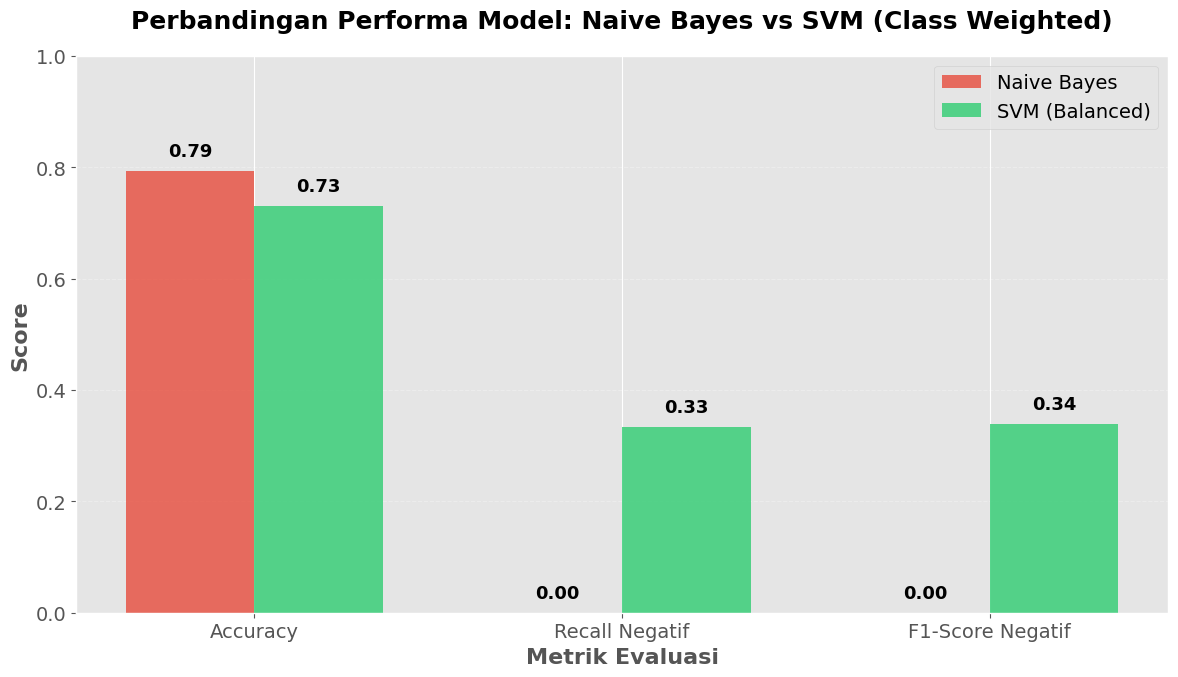


✅ Grafik 1 disimpan: poster_grafik_1_komparasi_model.png


In [71]:
# GRAFIK 1: PERBANDINGAN MODEL (Naive Bayes vs SVM)
# Untuk section "EVALUASI MODEL" di poster

# Ekstrak metrics dari classification_report
from sklearn.metrics import precision_recall_fscore_support

# Get predictions untuk kedua model
model_nb = models["Naive Bayes"]
model_svm = models["SVM (Balanced)"]

y_pred_nb = model_nb.predict(X_test_vect)
y_pred_svm = model_svm.predict(X_test_vect)

# Hitung metrics per kelas
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(y_test, y_pred_nb, labels=['Positif', 'Negatif'])
precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(y_test, y_pred_svm, labels=['Positif', 'Negatif'])

# Hitung accuracy
from sklearn.metrics import accuracy_score
acc_nb = accuracy_score(y_test, y_pred_nb)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Buat DataFrame untuk plotting
metrics_data = pd.DataFrame({
    'Naive Bayes': [acc_nb, recall_nb[1], f1_nb[1]],
    'SVM (Balanced)': [acc_svm, recall_svm[1], f1_svm[1]]
}, index=['Accuracy', 'Recall Negatif', 'F1-Score Negatif'])

print("\n📊 PERBANDINGAN MODEL:")
print(metrics_data.round(3))

# Visualisasi
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(metrics_data.index))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_data['Naive Bayes'], width, 
               label='Naive Bayes', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, metrics_data['SVM (Balanced)'], width,
               label='SVM (Balanced)', color='#2ecc71', alpha=0.8)

ax.set_ylabel('Score', fontweight='bold')
ax.set_xlabel('Metrik Evaluasi', fontweight='bold')
ax.set_title('Perbandingan Performa Model: Naive Bayes vs SVM (Class Weighted)', 
             fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_data.index)
ax.legend(loc='upper right')
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan nilai di atas bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.savefig('poster_grafik_1_komparasi_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafik 1 disimpan: poster_grafik_1_komparasi_model.png")

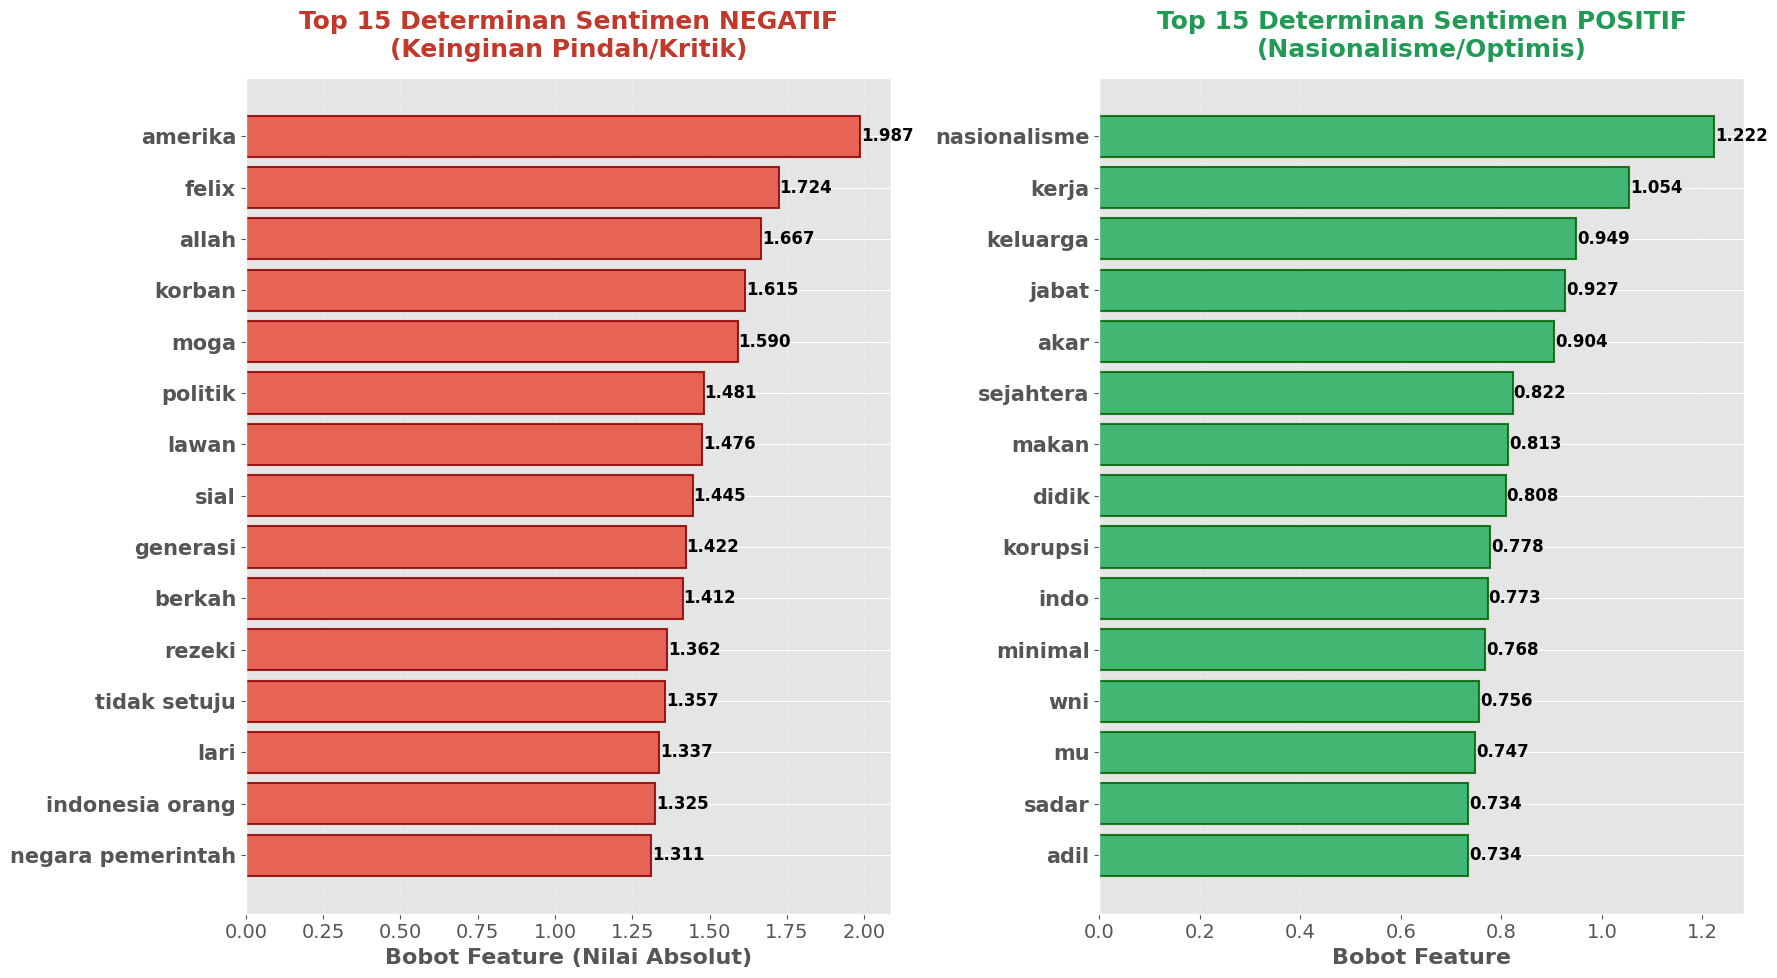


✅ Grafik 2 disimpan: poster_grafik_2_feature_importance.png

📌 Kata Kunci Negatif: ['amerika', 'felix', 'allah', 'korban', 'moga', 'politik', 'lawan', 'sial', 'generasi', 'berkah', 'rezeki', 'tidak setuju', 'lari', 'indonesia orang', 'negara pemerintah']
📌 Kata Kunci Positif: ['nasionalisme', 'kerja', 'keluarga', 'jabat', 'akar', 'sejahtera', 'makan', 'didik', 'korupsi', 'indo', 'minimal', 'wni', 'mu', 'sadar', 'adil']


In [72]:
# GRAFIK 2: FEATURE IMPORTANCE (Top 15 Kata Positif & Negatif)
# Untuk section "AKAR MASALAH" di poster

model_svm = models["SVM (Balanced)"]
feature_names = vectorizer.get_feature_names_out()
coefs = model_svm.coef_.toarray()[0]

df_features = pd.DataFrame({'kata': feature_names, 'bobot': coefs})

top_neg = df_features.nsmallest(15, 'bobot')
top_pos = df_features.nlargest(15, 'bobot')

# Buat visualisasi horizontal bar (lebih bagus untuk poster)
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot Negatif (Merah)
axes[0].barh(range(len(top_neg)), top_neg['bobot'].abs(), 
             color='#e74c3c', alpha=0.85, edgecolor='darkred', linewidth=1.5)
axes[0].set_yticks(range(len(top_neg)))
axes[0].set_yticklabels(top_neg['kata'], fontsize=15, fontweight='bold')
axes[0].set_xlabel('Bobot Feature (Nilai Absolut)', fontweight='bold', fontsize=16)
axes[0].set_title('Top 15 Determinan Sentimen NEGATIF\n(Keinginan Pindah/Kritik)', 
                  fontweight='bold', fontsize=18, pad=15, color='#c0392b')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Tambahkan nilai
for i, v in enumerate(top_neg['bobot'].abs()):
    axes[0].text(v + 0.002, i, f'{v:.3f}', 
                 va='center', fontweight='bold', fontsize=12)

# Plot Positif (Hijau)
axes[1].barh(range(len(top_pos)), top_pos['bobot'], 
             color='#27ae60', alpha=0.85, edgecolor='darkgreen', linewidth=1.5)
axes[1].set_yticks(range(len(top_pos)))
axes[1].set_yticklabels(top_pos['kata'], fontsize=15, fontweight='bold')
axes[1].set_xlabel('Bobot Feature', fontweight='bold', fontsize=16)
axes[1].set_title('Top 15 Determinan Sentimen POSITIF\n(Nasionalisme/Optimis)', 
                  fontweight='bold', fontsize=18, pad=15, color='#229954')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

# Tambahkan nilai
for i, v in enumerate(top_pos['bobot']):
    axes[1].text(v + 0.002, i, f'{v:.3f}', 
                 va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('poster_grafik_2_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafik 2 disimpan: poster_grafik_2_feature_importance.png")
print("\n📌 Kata Kunci Negatif:", top_neg['kata'].tolist())
print("📌 Kata Kunci Positif:", top_pos['kata'].tolist())

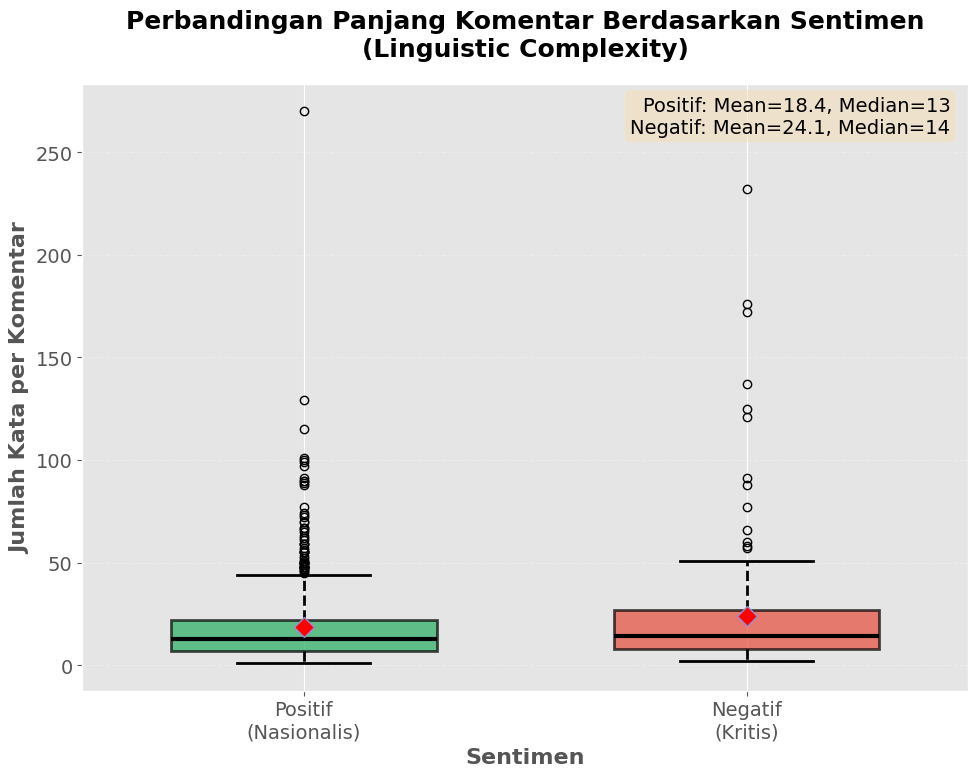


✅ Grafik 3 disimpan: poster_grafik_3_panjang_kata.png


In [73]:
# GRAFIK 3: BOXPLOT PANJANG KATA (Linguistic Patterns)
# Untuk section "POLA BAHASA" di poster

fig, ax = plt.subplots(figsize=(10, 8))

# Buat boxplot dengan style yang lebih menarik
bp = ax.boxplot([df[df['sentiment'] == 'Positif']['panjang_kata'],
                  df[df['sentiment'] == 'Negatif']['panjang_kata']],
                labels=['Positif\n(Nasionalis)', 'Negatif\n(Kritis)'],
                patch_artist=True,
                widths=0.6,
                showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=10))

# Warnai box
colors = ['#27ae60', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(2)

# Style lainnya
for whisker in bp['whiskers']:
    whisker.set(linewidth=2, linestyle='--')
for cap in bp['caps']:
    cap.set(linewidth=2)
for median in bp['medians']:
    median.set(linewidth=3, color='black')

ax.set_ylabel('Jumlah Kata per Komentar', fontweight='bold', fontsize=16)
ax.set_xlabel('Sentimen', fontweight='bold', fontsize=16)
ax.set_title('Perbandingan Panjang Komentar Berdasarkan Sentimen\n(Linguistic Complexity)', 
             fontweight='bold', fontsize=18, pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan statistik
stats_pos = df[df['sentiment'] == 'Positif']['panjang_kata']
stats_neg = df[df['sentiment'] == 'Negatif']['panjang_kata']

textstr = f'Positif: Mean={stats_pos.mean():.1f}, Median={stats_pos.median():.0f}\n'
textstr += f'Negatif: Mean={stats_neg.mean():.1f}, Median={stats_neg.median():.0f}'

ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('poster_grafik_3_panjang_kata.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafik 3 disimpan: poster_grafik_3_panjang_kata.png")

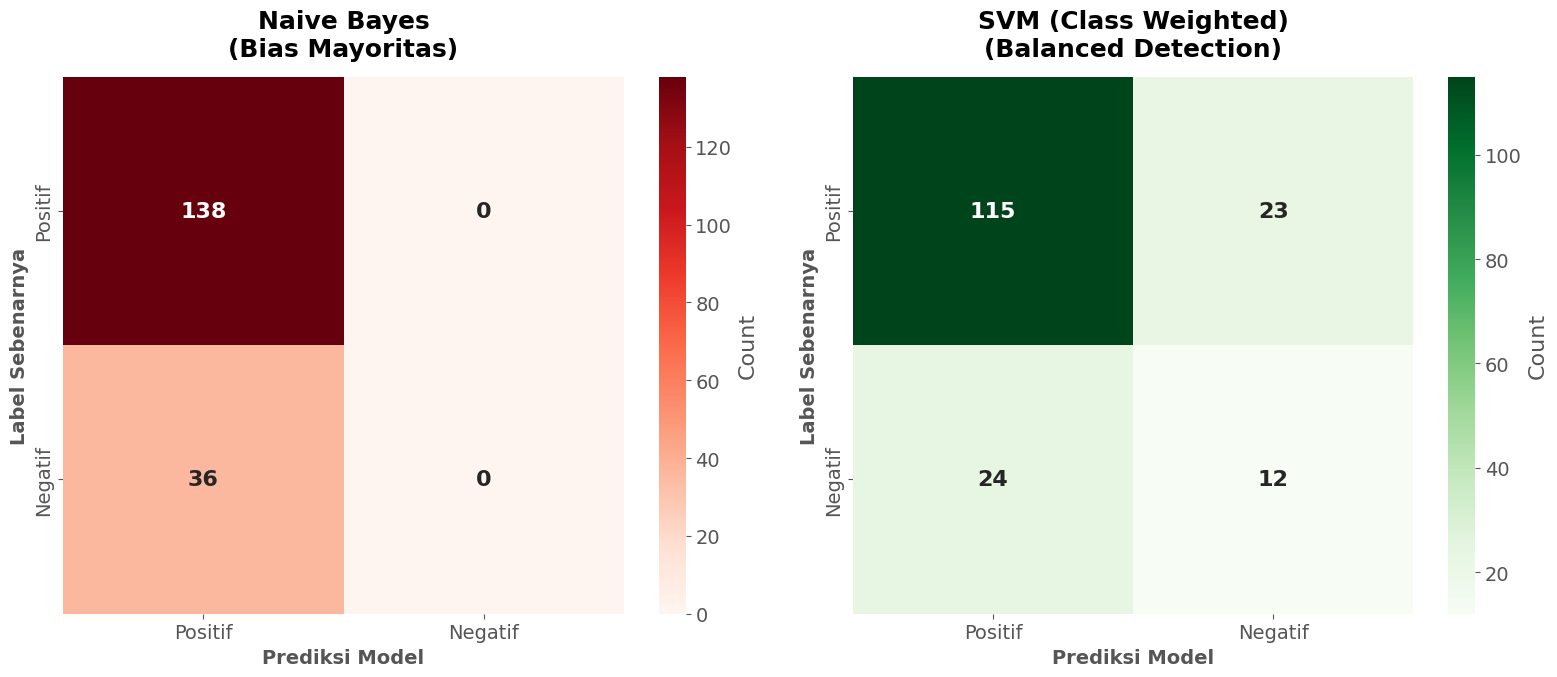


✅ Grafik 4 disimpan: poster_grafik_4_confusion_matrices.png


In [74]:
# GRAFIK 4 (BONUS): CONFUSION MATRIX SIDE-BY-SIDE
# Untuk membandingkan secara visual

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

from sklearn.metrics import confusion_matrix

# Confusion Matrix NB
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=['Positif', 'Negatif'])
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['Positif', 'Negatif'],
            yticklabels=['Positif', 'Negatif'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 16, 'weight': 'bold'})
axes[0].set_title('Naive Bayes\n(Bias Mayoritas)', fontweight='bold', fontsize=18, pad=15)
axes[0].set_ylabel('Label Sebenarnya', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Prediksi Model', fontweight='bold', fontsize=14)

# Confusion Matrix SVM
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=['Positif', 'Negatif'])
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Positif', 'Negatif'],
            yticklabels=['Positif', 'Negatif'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 16, 'weight': 'bold'})
axes[1].set_title('SVM (Class Weighted)\n(Balanced Detection)', fontweight='bold', fontsize=18, pad=15)
axes[1].set_ylabel('Label Sebenarnya', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Prediksi Model', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('poster_grafik_4_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafik 4 disimpan: poster_grafik_4_confusion_matrices.png")